In [1]:
import pandas as pd
teams = pd.read_csv("teams5sb.csv", index_col=[0,1])

teams.columns=[x.lower() for x in teams.columns]

In [2]:

# bramkarz-obrona-pomoc-atak-trener
# (PSxG-GA)/SoT; opp_xG; xG; Gls/xG
# ; SoTA; SCA; ;
bramkarz=['psxg','ga','sot']
obrona=['opp_xg','sota']
pomoc=['xg','sca']
atak=['gls','xg']
trener=['opp_xg'] #'opp_xg' vs AVGopp_xg

taktyka =['dist','cpa','1/3']# Dist(shot) C1/3 CPA
offence=['def pen','def 3rd','mid 3rd','att 3rd','att pen','touches'] #Touches[Def3rd Mid3rd Att3rd]/Touches
intensity=['touches']
wide=['sw','crs','att','opp_ti'] #/Poss Sw Crs Take-Ons[Att]'opp_ti'
speed=['poss','prgdist'] #PrgP/Poss poss/prgdist
stalefragmenty =['dead','fk','ti','ck', 'gca passdead'] #/Poss Dead,FK,TI,CK GCA pass dead
press=['sca def','tackles def 3rd', 'tackles mid 3rd', 'tackles att 3rd','tackles tkl','fls','won','opp_rec','opp_total cmp','opp_total att']
# SCA_Def,Tackles[Def3rd Mid3rd Att3rd], *oppRec, Fls AWon 
where=['tackles def 3rd','tackles mid 3rd','tackles att 3rd','def 3rd','mid 3rd','att 3rd','att pen','def pen']
error=['challenges lost','tackles tklw','tackles tkl','err','mis','dis','crdy','og','lost']
# ChallengesLost TklW/TklAtt Err Mis Dis CrdY OG Alost
succ=['int','tackles tklw','succ','challenges tkl','blocks','opp_total att','recov'] #Int TklW ChaTkl Take-Ons[Att] blocks 'opp_total att'

subset=bramkarz+obrona+pomoc+atak+trener+taktyka+offence+intensity+wide+speed+stalefragmenty+press+error+where
subset=list(set(subset))
len(subset)
df=teams[subset]
def norm(df):
    return (df-df.min())/(df.max()-df.min())
# norm(sel['xG']).sort_values()
# sel.rank(pct = True)
dfn=norm(df)
dfnr=dfn.reset_index(drop=True)

In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as MSE

import matplotlib.pyplot as plt
import numpy as np


In [77]:
# Create train/test split for initial holdout
from sklearn.model_selection import train_test_split

def reg_prep(dfnr,to_pred_cols_lst,test_size=0.3):
    # Create arrays for features and target variable
    df_to_pred= dfnr[to_pred_cols_lst]
    y = df_to_pred.values
    df_wo_y = dfnr.drop(to_pred_cols_lst,axis='columns')
    X = df_wo_y.values

    y_labels=df_to_pred.columns
    x_labels=df_wo_y.columns

    # Create training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=42)
    return X_train, X_test, y_train, y_test,x_labels,y_labels

def categorical_prep(df1,col):
# if CATEGORICAL data
# Create dummy variables: 
    df2=df1.join(pd.get_dummies(df1[col]))
    df2.drop([col],axis='columns', inplace=True)
    return df2

def categorical_code(pds):
    return pds.astype("category").cat.codes

def importants(labels,coefs):
    df1=pd.DataFrame()
    df1['a']=cols
    df1['b']=coefs
    df1=df1.sort_values('b',key=lambda x:-abs(x))[df1.b.abs()>0.02]
    return(df1)

X_train, X_test, y_train, y_test,cols,_ = reg_prep(dfnr,['xg'])

[[-1.55749715e-01 -7.03966329e-02 -4.77030627e+00  1.03520469e+00
   3.34389496e-02  9.21580125e-02 -2.26737863e-01  3.36631698e-02
  -7.81649825e-02  2.05801609e-02 -8.13511510e-02  1.48727140e-01
   5.08974330e-01 -6.49468940e-02 -1.06899970e-01  2.87641222e-04
  -6.77596754e-01  5.06874463e-02  3.88241569e-01 -1.81682662e-01
   1.05100837e-01  1.69082198e-02  4.81814451e-01  4.67850527e-01
  -5.49886845e-03  2.27401693e-02  6.23172227e-04 -3.10579254e+00
   2.87288357e-02 -7.25119762e-02  3.06600725e-01 -5.15286651e-02
   7.42693723e+00 -1.37459277e-02  2.11362986e-02 -1.82559540e-01
   2.12126467e-02 -1.90807801e-01  1.37733048e-01 -1.78522655e+00
   5.25099056e-03 -3.41890696e-02  1.95713850e-01 -7.96684501e-02
  -1.66288245e-01]]


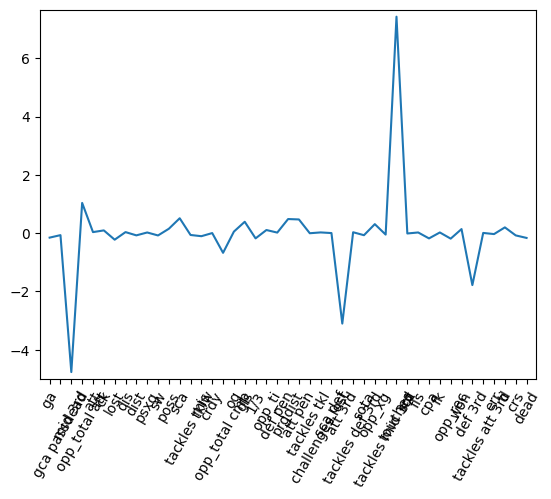

[0.14551535 0.5775951  0.52563051 0.91733008 0.90511202]
0.6142366122626024
R^2 on holdout
0.9462693700852486


In [78]:
# LinearRegression

# Import necessary modules
from sklearn.linear_model import LinearRegression

# Create the regressor: reg_all
reg = LinearRegression()

# Fit the regressor to the training data
reg.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg.predict(X_test)

# Compute and print the coefficients
print(reg.coef_)

# Plot the coefficients
plt.plot(range(len(cols)), reg.coef_[0])
plt.xticks(range(len(cols)), cols, rotation=60)
plt.margins(0.02)
plt.show()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg, X_train, y_train, cv=5)

# Print the 5-fold cross-validation scores
print(cv_scores)
print(np.mean(cv_scores))


# Compute and print R^2 on holdout
print('R^2 on holdout')
print(reg.score(X_test, y_test))

In [23]:

importants(cols,reg.coef_[0])

,a,b
2,mid 3rd,-4.770306
27,att 3rd,-3.105793
39,def 3rd,-1.785227
16,opp_total cmp,-0.677597
6,lost,-0.226738
37,opp_rec,-0.190808
35,cpa,-0.182560
19,1/3,-0.181683
44,dead,-0.166288
0,ga,-0.155750


[-0.          0.          0.         -0.          0.          0.
 -0.          0.         -0.         -0.          0.          0.
  0.         -0.         -0.         -0.         -0.         -0.
  0.10130713  0.         -0.         -0.          0.          0.10887443
 -0.         -0.          0.          0.         -0.         -0.
 -0.          0.          0.          0.19534699 -0.          0.
  0.         -0.         -0.         -0.          0.         -0.
  0.          0.         -0.        ]


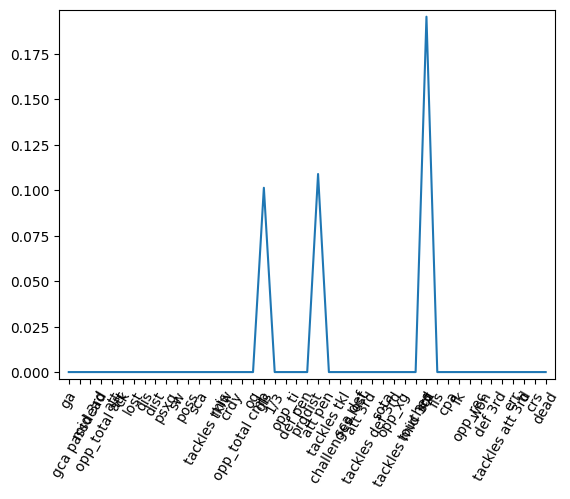

[0.60514666 0.69903007 0.45226705 0.55910887 0.35695329]
0.5345011856444494
R^2 on holdout
0.5991671653758843


In [47]:
#LASSO

# Import Lasso
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# # Instantiate a lasso regressor: lasso
# lasso = Lasso(alpha=0.3, normalize=True)

# # Fit the regressor to the data
# lasso.fit(X_train,y_train)


# Setup the pipeline steps: steps
steps = [
        # ('scaler', StandardScaler()),
        ('lasso', Lasso(alpha=0.02))
        ]
pipeline = Pipeline(steps)
lasso = pipeline.fit(X_train, y_train)
lasso_coef = pipeline.named_steps['lasso'].coef_
# Compute and print the coefficients
print(lasso_coef)

# Plot the coefficients
plt.plot(range(len(cols)), lasso_coef)
plt.xticks(range(len(cols)), cols, rotation=60)
plt.margins(0.02)
plt.show()

# Perform 5-fold cross-validation: 
lasso_cv = cross_val_score(lasso, X_train, y_train, cv=5)

# Print the cross-validated scores
print(lasso_cv)
print(np.mean(lasso_cv))

# Compute and print R^2 on holdout
print('R^2 on holdout')
print(lasso.score(X_test, y_test))

[[ 0.00438051  0.00084313  0.01258118 -0.02733354 -0.01099208  0.03464881
  -0.03303905 -0.01268622 -0.08023057  0.01656381  0.00136303  0.01770833
   0.1403557  -0.0016346  -0.09305566 -0.02755056 -0.03981906  0.0404369
   0.17581189 -0.03893769 -0.01046304 -0.04396688 -0.00760488  0.12364148
  -0.007007    0.00789826  0.00601227  0.0076482  -0.02437799 -0.04162694
  -0.01291995  0.00669021  0.00842331  0.16028473  0.01408633  0.05204215
  -0.02357682 -0.04035263  0.01971885 -0.01080299  0.01774915 -0.01284
   0.04898047 -0.04333588 -0.02071745]]


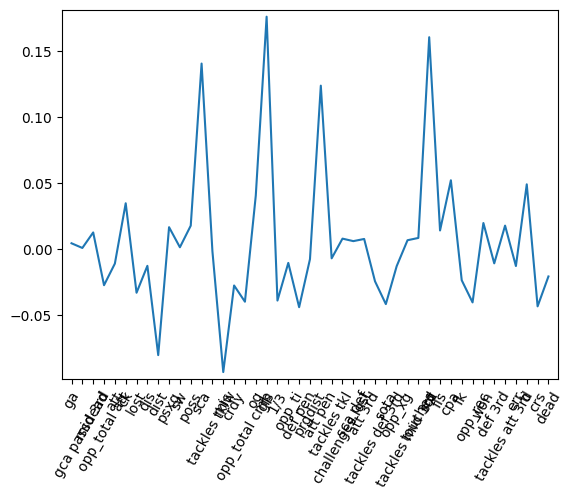

[0.77679996 0.79388465 0.86705389 0.84707941 0.95015713]
0.8469950073925439
R^2 on holdout
0.92490144909136
Test set RMSE: 0.067


In [48]:
# RIDGE

# Import necessary modules
from sklearn.linear_model import Ridge

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# Setup the pipeline steps: steps
steps = [
    # ('scaler', StandardScaler()),
        ('ridge', Ridge(alpha=0.8))]
pipeline = Pipeline(steps)
ridge = pipeline.fit(X_train, y_train)
ridge_coef = pipeline.named_steps['ridge'].coef_

# Compute and print the coefficients
print(ridge_coef)

# Plot the coefficients
plt.plot(range(len(cols)), ridge_coef[0])
plt.xticks(range(len(cols)), cols, rotation=60)
plt.margins(0.02)
plt.show()

# Perform 5-fold cross-validation: ridge_cv
ridge_cv = cross_val_score(ridge, X_train, y_train, cv=5)

# Print the cross-validated scores
print(ridge_cv)
print(np.mean(ridge_cv))

# Compute and print R^2 on holdout
print('R^2 on holdout')
print(ridge.score(X_test, y_test))

y_pred=ridge.predict(X_test)
# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)
# Print rmse_test
print('Test set RMSE: {:.3f}'.format(rmse_test))

[-0.          0.          0.         -0.          0.          0.
 -0.         -0.         -0.00079656 -0.          0.          0.
  0.0660367  -0.         -0.         -0.         -0.00507095  0.
  0.25000666  0.         -0.         -0.          0.          0.24754764
 -0.         -0.          0.          0.         -0.00334812 -0.
 -0.          0.          0.          0.17193399 -0.          0.
  0.         -0.01104216 -0.         -0.          0.         -0.
  0.          0.         -0.        ]


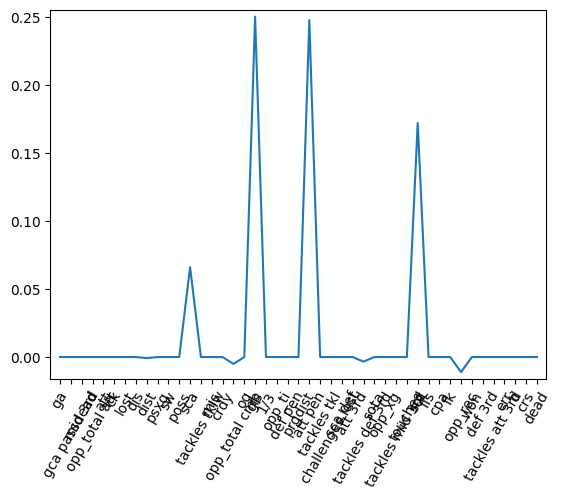

[0.86519082 0.8165682  0.81693877 0.80407855 0.86076216]
0.8327077001254486
R^2 on holdout
0.8828696104188998


In [52]:
#elastic net

from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# Setup the pipeline steps: steps
steps = [
    # ('scaler', StandardScaler()),
        ('elastic_net', ElasticNet(l1_ratio=0.6, alpha=0.01))]
pipeline = Pipeline(steps)
elastic_net = pipeline.fit(X_train, y_train)
elastic_net_coef = pipeline.named_steps['elastic_net'].coef_

# Compute and print the coefficients
print(elastic_net_coef)

# Plot the coefficients
plt.plot(range(len(cols)), elastic_net_coef)
plt.xticks(range(len(cols)), cols, rotation=60)
plt.margins(0.02)
plt.show()

# Perform 5-fold cross-validation: ridge_cv
elastic_net_cv = cross_val_score(elastic_net, X_train, y_train, cv=5)

# Print the cross-validated scores
print(elastic_net_cv)
print(np.mean(elastic_net_cv))

# Compute and print R^2 on holdout
print('R^2 on holdout')
print(elastic_net.score(X_test, y_test))



In [53]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE

In [54]:
# Import DecisionTreeRegressor from sklearn.tree
from sklearn.tree import DecisionTreeRegressor

# Instantiate dt
dt = DecisionTreeRegressor(max_depth=2, min_samples_leaf=0.3, random_state=3)

# Fit dt to the training set
dt.fit(X_train, y_train)

# Compute y_pred
y_pred = dt.predict(X_test)

# Compute mse_dt
mse_dt = MSE(y_pred, y_test)

# Compute rmse_dt
rmse_dt = mse_dt**(1/2)

# Print rmse_dt
print("Test set RMSE of dt: {:.2f}".format(rmse_dt))

Test set RMSE of dt: 0.15


In [56]:
# Compute the array containing the 10-folds CV MSEs
MSE_CV_scores = - cross_val_score(dt, X_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 

# Compute the 10-folds CV RMSE
RMSE_CV = (MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE: {:.2f}'.format(RMSE_CV))
# if CV RMSE is > Tree test set RMSE - means overfitting -> model too compilcated -> reduce parameters

CV RMSE: 0.11


In [55]:
# compare linear error vs tree error

# Predict test set labels 
y_pred_lr = reg.predict(X_test)

# Compute mse_lr
mse_lr = MSE(y_test, y_pred_lr)

# Compute rmse_lr
rmse_lr = mse_lr**(1/2)

# Print rmse_lr
print('Linear Regression test set RMSE: {:.2f}'.format(rmse_lr))

# Print rmse_dt
print('Regression Tree test set RMSE: {:.2f}'.format(rmse_dt))

Linear Regression test set RMSE: 0.06
Regression Tree test set RMSE: 0.15


In [69]:
# Random Forests
from sklearn.ensemble import RandomForestRegressor

# Instantiate rf
rf = RandomForestRegressor(n_estimators=25, random_state=2)
                           
# Fit rf to the training set   
y_train_1d= np.ravel(y_train)        
rf.fit(X_train, y_train_1d)

# Predict the test set labels
y_pred = rf.predict(X_test)

# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print rmse_test
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))

Test set RMSE of rf: 0.09


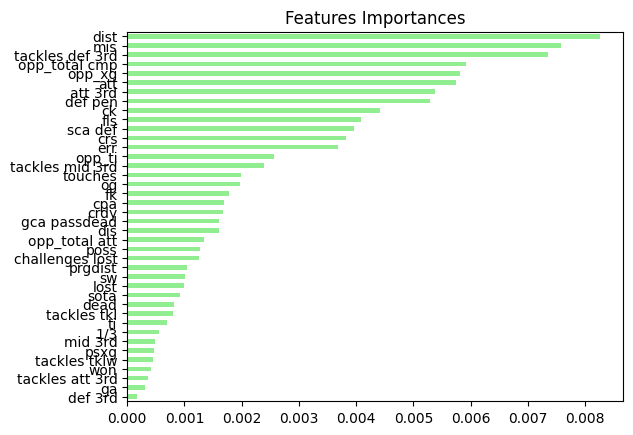

In [70]:
# Create a pd.Series of features importances
importances = pd.Series(data=rf.feature_importances_, index= cols)

# Sort importances
importances_sorted = importances.sort_values()[:40]

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

In [72]:
#Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor

# Instantiate gb
gb = GradientBoostingRegressor(max_depth=3,n_estimators=200,random_state=2)

# Fit gb to the training set
gb.fit(X_train, y_train_1d)

# Predict test set labels
y_pred = gb.predict(X_test)

# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print RMSE
print('Test set RMSE of gb: {:.3f}'.format(rmse_test))

Test set RMSE of gb: 0.089


In [73]:
#Stochastic Gradient Boosting (SGB)

# Import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Instantiate sgbr
sgbr = GradientBoostingRegressor(max_depth=4, 
                                 subsample=0.8,
                                 max_features=0.4,
                                 n_estimators=200,                                
                                 random_state=2)

# Fit sgbr to the training set
sgbr.fit(X_train, y_train_1d)

# Predict test set labels
y_pred = sgbr.predict(X_test)

# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print rmse_test
print('Test set RMSE of sgbr: {:.3f}'.format(rmse_test))

Test set RMSE of sgbr: 0.096
